In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
import numpy as np
import os
from dask.distributed import Client
# Optional modules
import xgcm
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=56) # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 56
Total threads: 56,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37079,Workers: 56
Dashboard: /proxy/8787/status,Total threads: 56
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35109,Total threads: 1
Dashboard: /proxy/46751/status,Memory: 4.46 GiB
Nanny: tcp://127.0.0.1:37197,


In [3]:
import cosima_cookbook as cc
session = cc.database.create_session()

## Basic Check

Test to check if the ASC speed calculated monthly and averaged afterwards gets the field as fould by Wilma

In [4]:
#importing [Monthly] ASC speed from year 2095 to 2098
import glob
src = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF/Antarctic_slope_contour_1km_velocities_209'
gl =glob.glob(src + "****_uv.nc")
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
##importing data from ocean.nc
Along_slope_v=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
Along_slope_v_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

48 netcdf data files


In [5]:
# fig = plt.figure(figsize=(10,3))

# plt.subplot(1,2,1)
# plt.pcolormesh(Along_slope_v.u_along_contour,vmin=-0.3, vmax=0.3,cmap='seismic')
# plt.colorbar()


# plt.subplot(1,2,2)
# plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
#             c=Along_slope_v.u_along_contour.isel(st_ocean=0),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
# plt.colorbar()
# #seems to be the same as the plot in calc_u_on_depth_contour.ipynb 

It seems correct on a annual mean. Lets see accross the months

In [6]:
%%time
#First fixing the time dimension
experiment = '01deg_jra55v13_ryf9091'
variable = 'time'
start_time='2095-01-01'
end_time='2098-12-31'

timedim = cc.querying.getvar(experiment, 'time', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
timedim = timedim.isel(time=slice(4,100,2)) #Only 2080 and 2081
Along_slope_v_time['time']=timedim.time

CPU times: user 54.8 s, sys: 19.5 s, total: 1min 14s
Wall time: 1min 50s


In [7]:
# fig = plt.figure(figsize=(20,20))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.1,
#                     hspace=0.4)





# for imonth in np.arange(0,12):
#     plt.subplot(6,2,imonth+1)
#     plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
#                 c=Along_slope_v_time.u_along_contour.isel(st_ocean=0,time=imonth),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
#     plt.title('2095/' + str(imonth+1))
#     plt.colorbar()

Interesting, on the Weddell and Ross Sea ASC **at surface** seem to be stronger in the Autumn and Winter

In [8]:
# fig = plt.figure(figsize=(20,20))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.1,
#                     hspace=0.4)


# for imonth in np.arange(0,12):
#     plt.subplot(6,2,imonth+1)
#     plt.pcolormesh(Along_slope_v_time.u_along_contour.isel(time=imonth),vmin=-0.3, vmax=0.3,cmap='seismic')
#     plt.title('2095/' + str(imonth+1))
#     plt.colorbar()

Now lets plot mean ASC and Standard Deviation, just so see what it shows.

In [9]:
#calculating STDs for the whole 2 years
Along_slope_v_time_std = Along_slope_v_time.u_along_contour.std(dim='time')

Plotting now

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


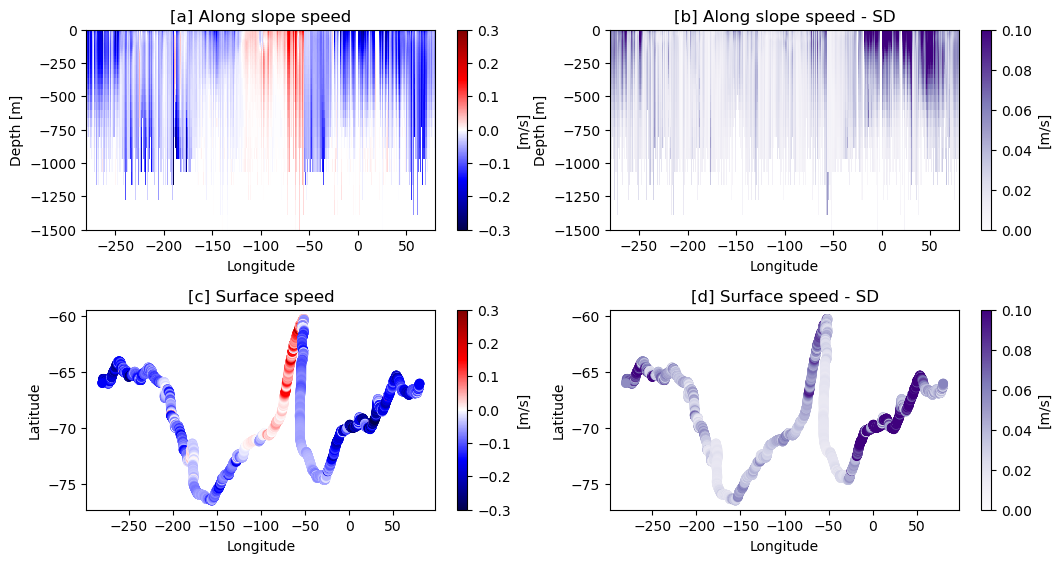

In [10]:
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)



plt.subplot(2,2,1)
plt.pcolormesh(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(0,4486)),-Along_slope_v.st_ocean,
         Along_slope_v.u_along_contour.isel(distance_along_contour=slice(0,4486)),vmin=-0.3, vmax=0.3,cmap='seismic')

plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.colorbar(label='[m/s]')
plt.title('[a] Along slope speed')

plt.subplot(2,2,2)

plt.pcolormesh(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(0,4486)),-Along_slope_v.st_ocean,
         Along_slope_v_time_std.isel(distance_along_contour=slice(0,4486)),vmin=0, vmax=0.1,cmap='Purples')
plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.title('[b] Along slope speed - SD')
plt.colorbar(label='[m/s]')

plt.subplot(2,2,3)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[c] Surface speed')
plt.colorbar(label='[m/s]')

plt.subplot(2,2,4)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v_time_std.isel(st_ocean=0),vmin=0, vmax=0.1, s=35, cmap='Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[d] Surface speed - SD')
plt.colorbar(label='[m/s]')

Further analysis to make:
    1-Spatial mean of ASC U(s,t)( Should I delete the Antarctic Peninsula?). Get temporal variability along Antarctica
    2-Import cross slope heat transport for the same period. How is the mean? How is the Variability along space(STD) and time (same as 1 for heat transport)

## Mean ASC speed 

I will calculate the spatial average of the ASC speed in two cases, C1 using all the velocities, and C2 will be removing the West Antarctic Peninsula.

Frist lets separate the indexes of the Antarctic peninsulat to be remove from the account. The area between minrange and macrange will be out of the count in C2

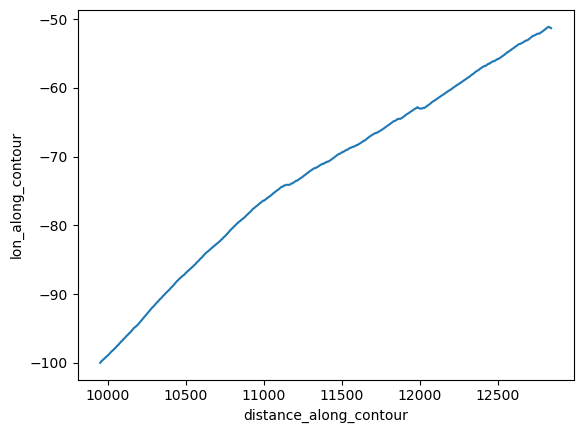

In [11]:
minrange=2144
maxrange=minrange+540
minlon=np.nanmin(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))
maxlon=np.nanmax(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))
Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)).plot()
# plt.title("minlon= " + str(minlon) +
#          " and maxlon = " + str(maxlon))

In [12]:
np.nanmin(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1))),np.nanmax(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))

(-100.00000000000345, -51.1000000000053)

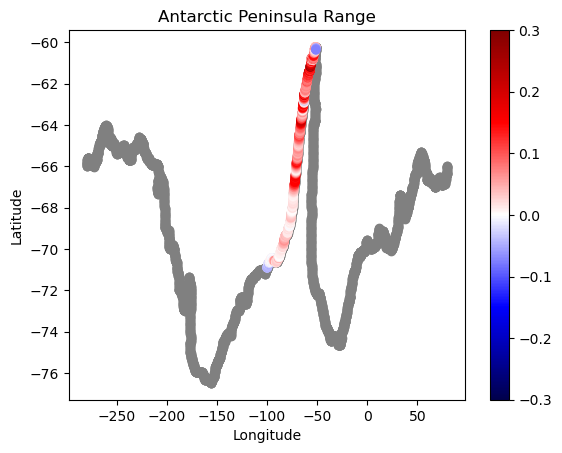

In [13]:
minrange=2144
maxrange=minrange+540
plt.scatter(Along_slope_v.lon_along_contour,
            Along_slope_v.lat_along_contour, 
            color='grey')
plt.scatter(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)),
            Along_slope_v.lat_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)), 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0).isel(distance_along_contour=slice(minrange,maxrange,1))
            ,vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Antarctic Peninsula Range')
plt.colorbar()

In [14]:
#Importing dzt and tarea for averaging
dzt = cc.querying.getvar(experiment, 'dzt', session, n=1).isel(time=0)
dzt_along_contour = dzt.sel(xt_ocean=Along_slope_v.lon_along_contour,yt_ocean=Along_slope_v.lat_along_contour,method='nearest')

tarea = cc.querying.getvar(experiment, 'tarea', session, n=1)
tarea = tarea.rename(nx='xt_ocean',ny='yt_ocean')
tarea['xt_ocean']=dzt.xt_ocean
tarea['yt_ocean']=dzt.yt_ocean
tarea_along_contour = tarea.sel(xt_ocean=Along_slope_v.lon_along_contour,yt_ocean=Along_slope_v.lat_along_contour,method='nearest')

Checking the area to see if it is correct

(-80.0, -50.0)

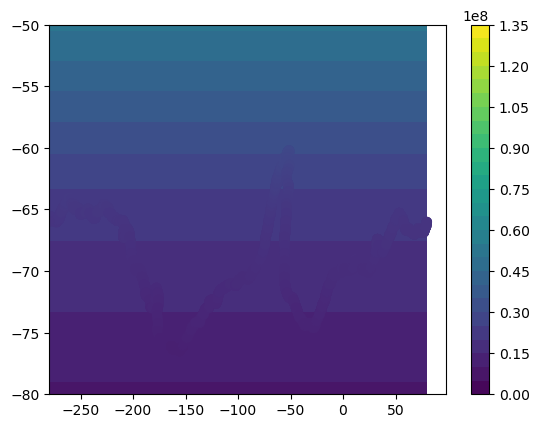

In [15]:
plorange=np.arange(0,1.4e8,5e6)
plt.contourf(dzt.xt_ocean,dzt.yt_ocean,tarea,plorange)
plt.colorbar()
plt.scatter(Along_slope_v.lon_along_contour,
            Along_slope_v.lat_along_contour,c=np.array(tarea_along_contour),
            vmin=-0, vmax=1.4e8, s=40)
plt.ylim(-80,-50)


Since Areas Along the line contour are similar to the grid plot of areas, then the extraction is probably right

Calculating the total mean ASC flux (C1)

In [16]:
%%time
# First calculating the volume to use as a weight
vol_along_contour=tarea_along_contour*dzt_along_contour

#first month is 
ASC_u = np.nansum(Along_slope_v_time.u_along_contour.isel(time=0)*vol_along_contour)/np.nansum(vol_along_contour)

for n in np.arange(1,48):
    ASC_u0=Along_slope_v_time.u_along_contour.isel(time=n)
    ASC_u1=np.nansum(ASC_u0*vol_along_contour)/np.nansum(vol_along_contour)
    ASC_u = np.append(ASC_u,ASC_u1)

CPU times: user 1min 23s, sys: 9.95 s, total: 1min 33s
Wall time: 1min 38s


Now calculating the same only in the AP, so we can remove it from the C1 to obtain C2

In [17]:
%%time
#first month is 
ASC_uAP = np.nansum(Along_slope_v_time.u_along_contour.isel(time=0).isel(distance_along_contour=slice(minrange,maxrange,1))*vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))/np.nansum(vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))

for n in np.arange(1,48):
    ASC_u0=Along_slope_v_time.u_along_contour.isel(time=n).isel(distance_along_contour=slice(minrange,maxrange,1))
    ASC_u1=np.nansum(ASC_u0*vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))/np.nansum(vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))
    ASC_uAP = np.append(ASC_uAP,ASC_u1)

CPU times: user 1min 26s, sys: 10 s, total: 1min 36s
Wall time: 1min 41s


ASC speed without the AP speed  (C2) will be ASC_u -  ASC_uAP:

In [18]:
ASC_unoAP=ASC_u-ASC_uAP

Text(0.5, 1.0, '01deg_jra55v13_ryf9091: yr 2095 to 2098')

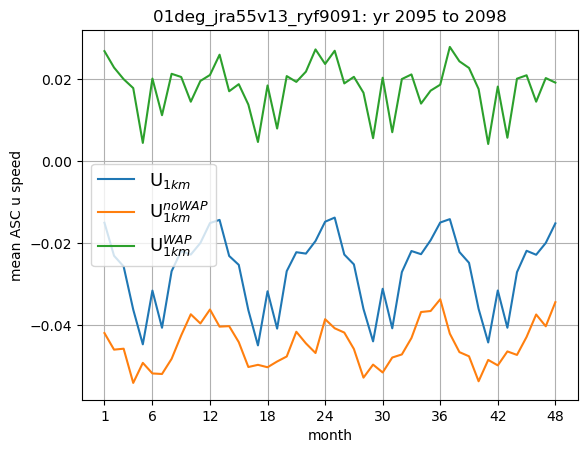

In [19]:
plt.plot(np.arange(1,49),ASC_u,label=r'U$_{1km}$')
plt.plot(np.arange(1,49),ASC_unoAP,label=r'U$_{1km}^{noWAP}$')
plt.plot(np.arange(1,49),ASC_uAP,label=r'U$_{1km}^{WAP}$')
plt.xlabel('month')
plt.ylabel('mean ASC u speed')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])
plt.legend(fontsize=13)
plt.title(experiment + ': yr 2095 to 2098')

Interesting that it changes the month og the peak when we include or not the AP.

Lets now compare what we find here with the Cross-slope heat transport

## Cross slope heat transport

First, lets import the heat transports

In [20]:
#importing Cross 1000m isobath heat transport
src = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v13_ryf9091/Ant_cross_slope_heat_terms_online_1000m_209'
gl =glob.glob(src + "****.nc")
gl=sorted(gl)
Heat_transp=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
Heat_transp_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

In [21]:
#Substituting the time dimension
Heat_transp_time['time']=timedim.time

Lets Calculate the STD for the heat transport. Does it resemble the ASC speed std? (Is variability in speed and cross shelf ehat transport similar?)

In [22]:
factor=0.08130129165602648

In [23]:
Heat_transp_time_std=Heat_transp_time.cross_slope_heat_trans.std(dim='time')
Heat_transp_time_CONTOUR_std=Heat_transp_time.heat_trans_across_contour.std(dim='time')
Cross_slope_heat_trans_std = (Heat_transp_time.cross_slope_heat_trans*factor - Heat_transp_time.zonal_convergence*factor).std(dim='time')

The lat_along_contour, wasnt saved in the entcdf. SI just will collate it here so we can have the appropriate indexing)

In [24]:
lat_along_contour=xr.open_dataset('/g/data/x77/wf4500/ASC_project/cross_slope_transport/lat_along_contour.nc')
lat_along_contour= lat_along_contour.__xarray_dataarray_variable__

In [25]:
xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=-1)
yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=-1).isel(yt_ocean=slice(0,510))

grid=xr.open_dataset('/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m_noSrestoring/wf4500/access-om2/archive/ryf_noSrestoring/output000/ocean/ocean_grid.nc')
ht = grid.ht.isel(yt_ocean=slice(0,510))
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)

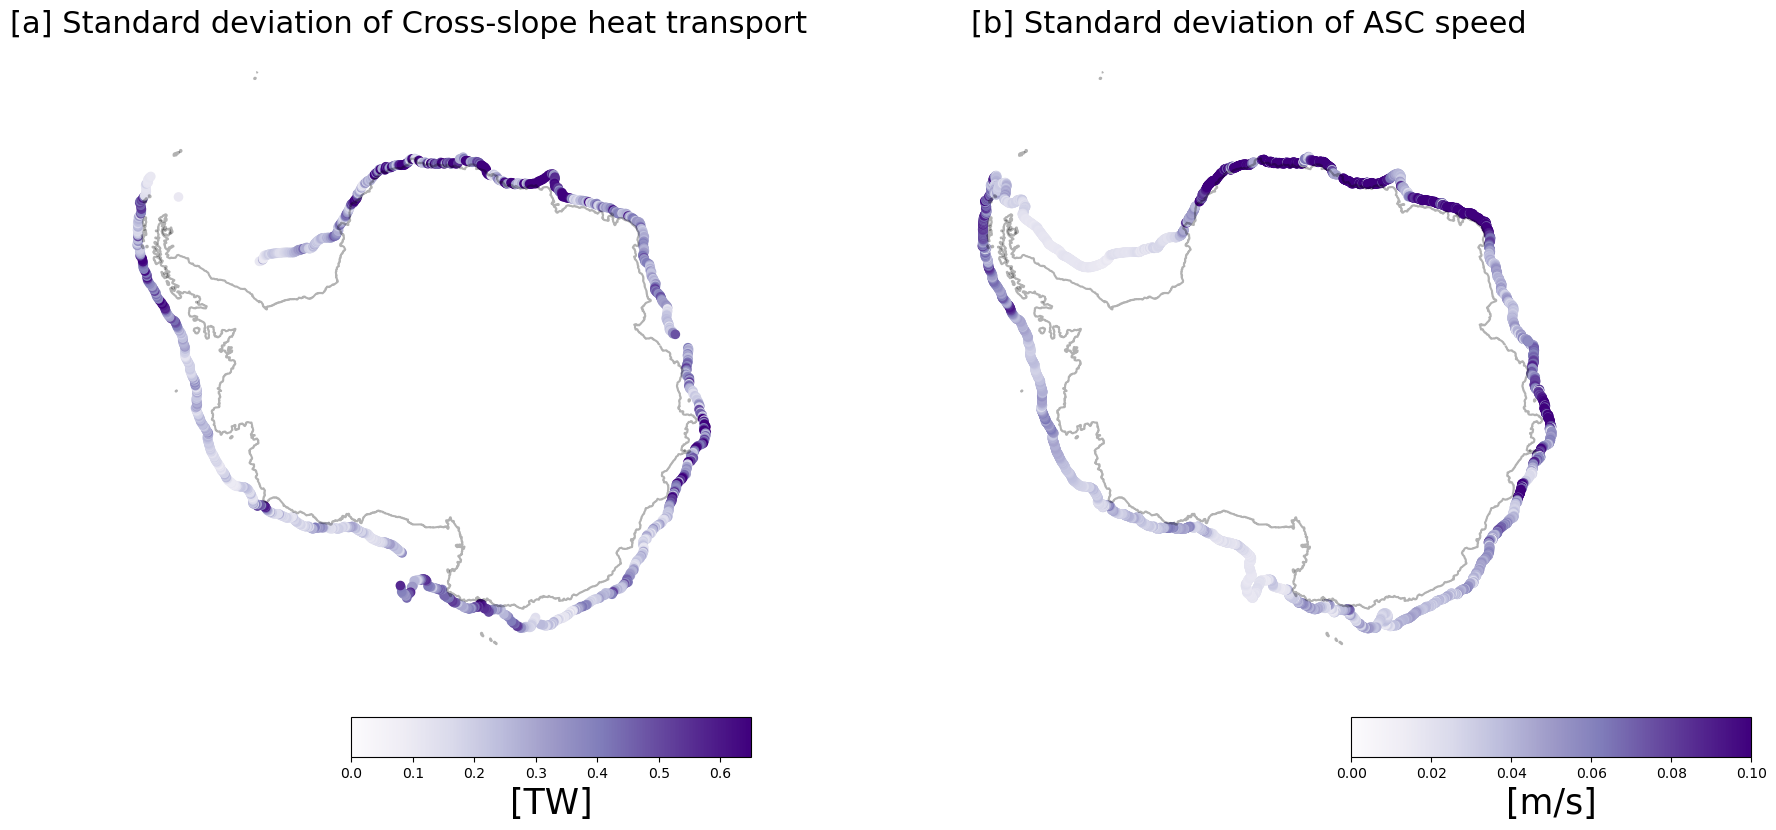

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cft
from matplotlib import gridspec
import matplotlib.path as mpath
import matplotlib.colors as col

fig  = plt.figure(1, figsize = (20, 10))
fig.tight_layout(pad=5.0)
gs = gridspec.GridSpec(1,2, width_ratios = [2, 2]) 
gs.update(wspace = 0.2)

ax, ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean,land_mask, [0, 1],
           colors = 'k', alpha = 0.3, transform = ccrs.PlateCarree() )
#ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask, [0, 1],
#           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt = ax.scatter(Heat_transp.lon_bin_midpoints, Heat_transp.lat_bin_midpoints, 
            c=Cross_slope_heat_trans_std/1e12,\
            vmin=0, vmax=0.65, s=35,  cmap='Purples',transform=ccrs.PlateCarree())

ax.set_title("[a] Standard deviation of Cross-slope heat transport ",fontsize=22)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
#ax.outline_patch.set_visible(False)
ax.spines['geo'].set_edgecolor('white')
cax = fig.add_axes([0.27, 0.13, 0.2, 0.04])
cbar=plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.1)
cbar.set_label(r'[TW]', fontsize = 25)



ax1.contour(xt_ocean, yt_ocean,land_mask, [0, 1],
           colors = 'k', alpha = 0.3, transform = ccrs.PlateCarree() )
#ax1.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask, [0, 1],
#           colors='k', alpha =0.8, transform = ccrs.PlateCarree())

norm = col.Normalize(vmin=0, vmax=2.5)

plot_swmt1 = ax1.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v_time_std.isel(st_ocean=0),vmin=0, vmax=0.1, s=35, cmap='Purples',transform=ccrs.PlateCarree())

ax1.set_title("[b] Standard deviation of ASC speed  ",fontsize=22)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
ax1.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
#ax.outline_patch.set_visible(False)
ax1.spines['geo'].set_edgecolor('white')
cax = fig.add_axes([0.77, 0.13, 0.2, 0.04])
cbar=plt.colorbar(plot_swmt1, cax=cax, orientation='horizontal', shrink = 0.1,)
cbar.set_label(r'[m/s]', fontsize = 25)

plt.savefig( 'HT.png')


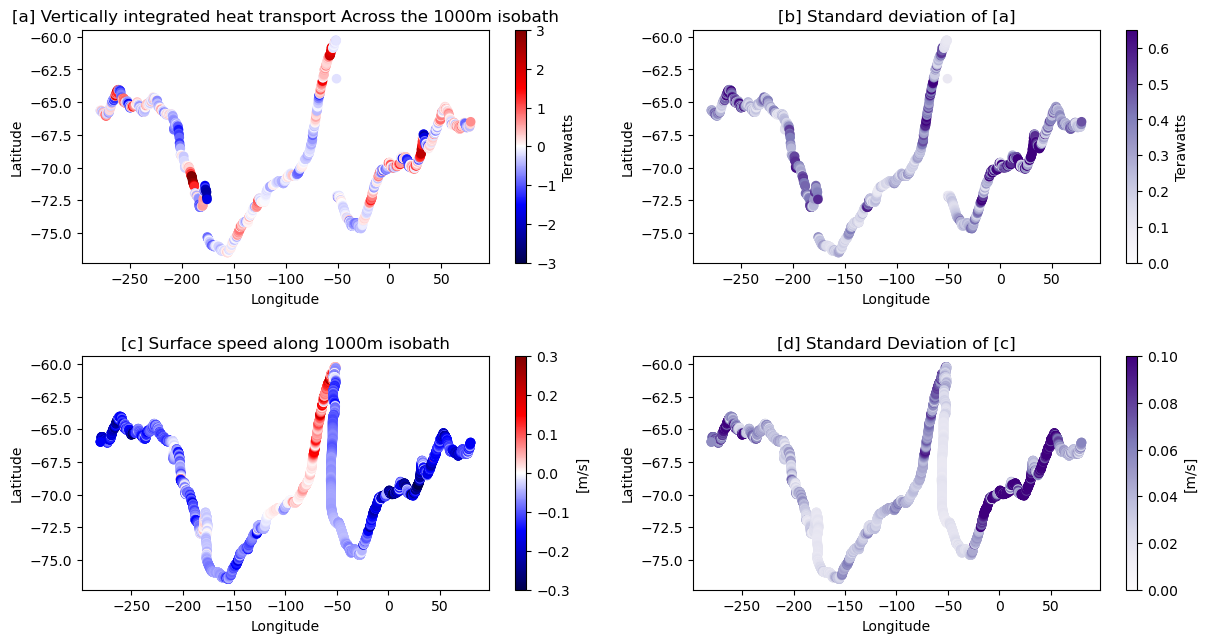

In [27]:
fig = plt.figure(figsize=(14,7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)



plt.subplot(2,2,1)
#plt.scatter(Heat_transp.lon_along_contour, lat_along_contour, 
#            c=Heat_transp.heat_trans_across_contour/1e12,vmin=-3, vmax=3, s=35, cmap='seismic')
plt.scatter(Heat_transp.lon_bin_midpoints, Heat_transp.lat_bin_midpoints, 
            c=(Heat_transp.cross_slope_heat_trans*factor - Heat_transp.zonal_convergence*factor)/1e12,vmin=-3, vmax=3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[a] Vertically integrated heat transport Across the 1000m isobath')
plt.colorbar(label='Terawatts')

plt.subplot(2,2,2)
#plt.scatter(Heat_transp.lon_along_contour, lat_along_contour, 
#            c=Heat_transp_time_CONTOUR_std/1e12,vmin=0, vmax=0.8, s=35, cmap='Purples')
plt.scatter(Heat_transp.lon_bin_midpoints, Heat_transp.lat_bin_midpoints, 
            c=Cross_slope_heat_trans_std/1e12,vmin=0, vmax=0.65, s=35, cmap='Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[b] Standard deviation of [a]')
plt.colorbar(label='Terawatts')

plt.subplot(2,2,3)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[c] Surface speed along 1000m isobath')
plt.colorbar(label='[m/s]')

plt.subplot(2,2,4)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v_time_std.isel(st_ocean=0),vmin=0, vmax=0.1, s=35, cmap='Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[d] Standard Deviation of [c]')
plt.colorbar(label='[m/s]')

The regions with high variability in ASC along-slope speed definitely seem to have some strong variability in ASC cross slope heat transport. The key regions seem to be:

R1 - Eastern Weddell Sea

R2 - Western Antarctic Peninsula

R3 - Eastern Prydz bay

Lets calculate a timeseries of cross slope heat transport, in a similar way as we didi for the ASC speed (two ways)

#### Integrated heat transport

Getting the ranges of the Antarctic Peninsula in the Cross Slope heat Transport

In [28]:
Heat_transp.lat_bin_midpoints

<xarray.DataArray 'lat_bin_midpoints' (lat_bin_midpoints: 1428)>
array([-65.627908, -65.585669, -65.627908, ..., -66.683892, -66.683892,
       -66.493815])
Coordinates:
  * lat_bin_midpoints  (lat_bin_midpoints) float64 -65.63 -65.59 ... -66.49

In [29]:
# Heat_transp.lon_bin_midpoints.plot()

In [30]:
#We want this range (-100.00000000000345, -51.1000000000053)
minrange1=714
maxrange1=minrange1+196
minlon=np.nanmin(Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)))
maxlon=np.nanmax(Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)))
#Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)).plot()
# plt.title("minlon= " + str(minlon) +
#          " and maxlon = " + str(maxlon))


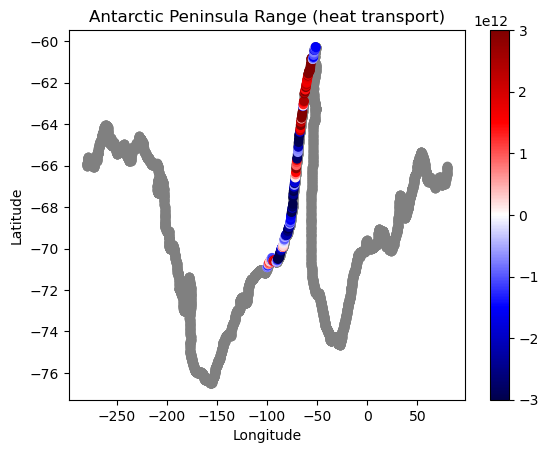

In [31]:
minrange1=714
maxrange1=minrange1+196
plt.scatter(Heat_transp.lon_along_contour,
            lat_along_contour, 
            color='grey')
plt.scatter(Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)),
            Heat_transp.lat_bin_midpoints.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)), 
            c=Heat_transp.cross_slope_heat_trans.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1))
            ,vmin=-0.3e13, vmax=0.3e13, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Antarctic Peninsula Range (heat transport)')
plt.colorbar()

In [32]:
#Importing tarea for averaging (2dvar averaged by area)
tarea_along_contour1 = tarea.sel(xt_ocean=Heat_transp.lon_bin_midpoints[10],yt_ocean=Heat_transp.lat_bin_midpoints,method='nearest')
#longitude 10 was chosen randomly ehre, as the longitude doesnt matter for the Area, only the Latitude

In [33]:
%%time

#first month is 
HT_1km = np.nansum(Heat_transp_time.cross_slope_heat_trans.isel(time=0)*tarea_along_contour1)/np.nansum(tarea_along_contour1)

for n in np.arange(1,48):
    HT_1km0=Heat_transp_time.cross_slope_heat_trans.isel(time=n)
    HT_1km1=np.nansum(HT_1km0*tarea_along_contour1)/np.nansum(tarea_along_contour1)
    HT_1km = np.append(HT_1km,HT_1km1)

CPU times: user 8.7 s, sys: 2.34 s, total: 11 s
Wall time: 15.1 s


Discounting the HT along the AP

In [34]:
%%time
#NOtice that here I need to sum the zonal convergence
#first month is 
HT_AP_1km = (np.nansum( (Heat_transp_time.cross_slope_heat_trans + Heat_transp_time.zonal_convergence)\
                       .isel(time=0).isel(lon_bin_midpoints=slice(minrange1,maxrange1,1))*tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)))/np.nansum(tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1))))

for n in np.arange(1,48):
    HT_AP_1km0=(Heat_transp_time.cross_slope_heat_trans + Heat_transp_time.zonal_convergence).isel(time=n).isel(lon_bin_midpoints=slice(minrange1,maxrange1,1))
    HT_AP_1km1=np.nansum(HT_AP_1km0*tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)))/np.nansum(tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)))
    HT_AP_1km = np.append(HT_AP_1km,HT_AP_1km1)

CPU times: user 7.86 s, sys: 1.44 s, total: 9.3 s
Wall time: 12.9 s


In [35]:
HTnoAP_1km=HT_1km-HT_AP_1km

How is the temporal variability of the heat transport across 1km isobath?

Text(0.5, 1.0, '01deg_jra55v13_ryf9091: yr 2095 to 2098')

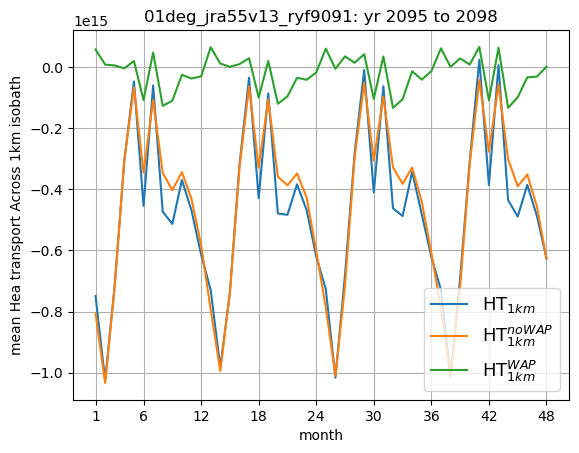

In [36]:
plt.plot(np.arange(1,49),HT_1km,label=r'HT$_{1km}$')
plt.plot(np.arange(1,49),HTnoAP_1km,label=r'HT$_{1km}^{noWAP}$')
plt.plot(np.arange(1,49),HT_AP_1km,label=r'HT$_{1km}^{WAP}$')
plt.xlabel('month')
plt.ylabel('mean Hea transport Across 1km isobath')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])
plt.legend(fontsize=13,loc='lower right')
plt.title(experiment + ': yr 2095 to 2098')

Ok, it is kind of weird that the AP makes no difference in the Integrated heat transport. mhmm

The results above are for the heat_transp_accross_contour Var, which in total should have the same value as the cross_slope_heat_trasport. However, the heat_transport_across_contour includes the zonal heat convergence in it ( which needs to be discounted). Therefore to reduct the AP, we need to use the Cross_contour_heat_transp, and reduce the zonal convergence from it

### ASC speed VS Cross slope heat Transport

Lets see the HT vs the ASC speed now

Text(0, 0.5, 'Cross slope Heat Transport [TW]')

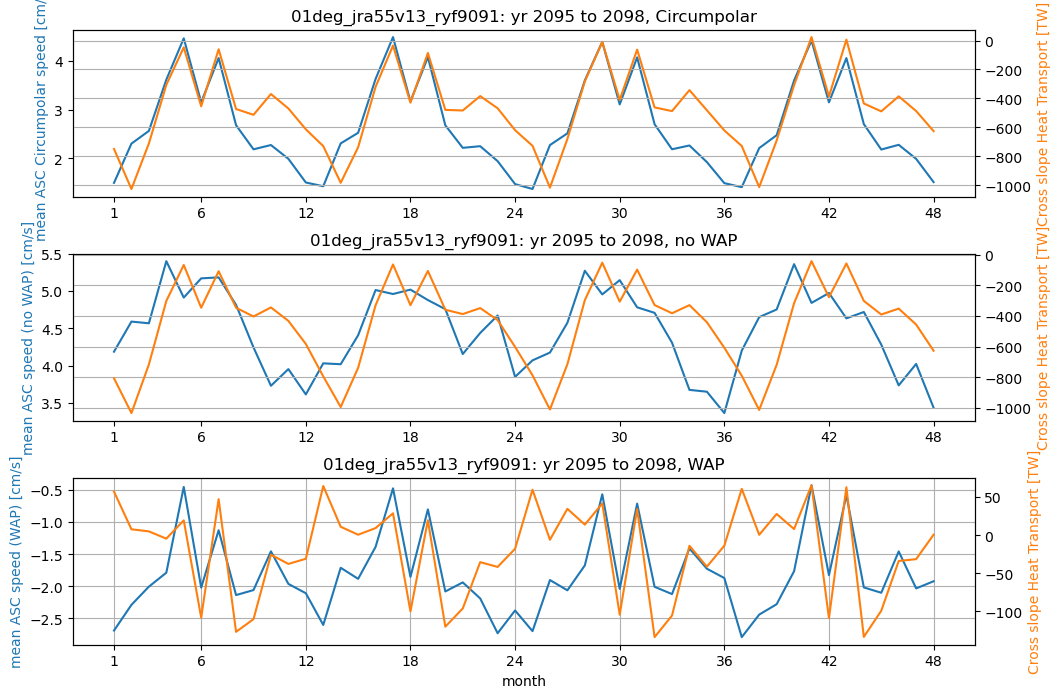

In [37]:
fig,ax = plt.subplots(3,1,figsize=(10, 7))
fig.tight_layout(pad=2.0)

#subplot1
ax[0].set_title(experiment + ': yr 2095 to 2098, Circumpolar')
ax[0].plot(np.arange(1,49),-ASC_u*100,label=r'U$_{1km}$',color='tab:blue')
plt.xlabel('month')
ax[0].set_ylabel('mean ASC Circumpolar speed [cm/s]',color='tab:blue')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])




ax2=ax[0].twinx()
plt.plot(np.arange(1,49),HT_1km/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax2.set_ylabel('Cross slope Heat Transport [TW]',color='tab:orange')


#subplot2
ax[1].set_title(experiment + ': yr 2095 to 2098, no WAP')
ax[1].plot(np.arange(1,49),-ASC_unoAP*100,label=r'U$_{1km}$',color='tab:blue')
plt.xlabel('month')
ax[1].set_ylabel('mean ASC speed (no WAP) [cm/s]',color='tab:blue')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])



ax3=ax[1].twinx()
plt.plot(np.arange(1,49),HTnoAP_1km/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax3.set_ylabel('Cross slope Heat Transport [TW]',color='tab:orange')



#subplot3
ax[2].set_title(experiment + ': yr 2095 to 2098, WAP')
ax[2].plot(np.arange(1,49),-ASC_uAP*100,label=r'U$_{1km}$',color='tab:blue')
plt.xlabel('month')
ax[2].set_ylabel('mean ASC speed (WAP) [cm/s]',color='tab:blue')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])



ax4=ax[2].twinx()
plt.plot(np.arange(1,49),HT_AP_1km/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax4.set_ylabel('Cross slope Heat Transport [TW]',color='tab:orange')

On a spatial mean, it definetly seem that the stronger the ASC, the weaker is the cross-slope heat transport. On a total spatial average

What about some simple dispersion plot

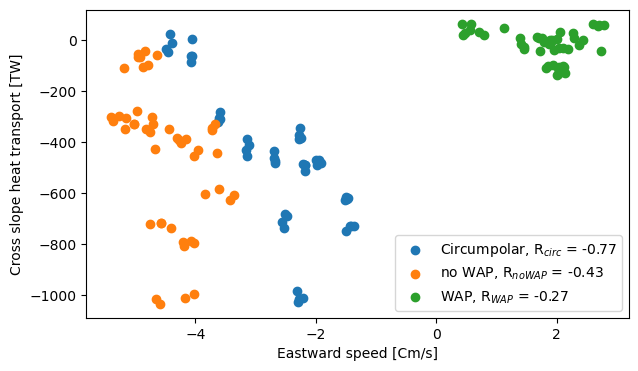

In [38]:
fig,ax = plt.subplots(figsize=(7, 4))
# the correlation:
coeffpC = np.corrcoef(ASC_u,HT_1km/1e12)
coeffpnoAP = np.corrcoef(ASC_unoAP,HTnoAP_1km/1e12)
coeffpAP = np.corrcoef(ASC_uAP,HT_AP_1km/1e12)
#the plot
plt.scatter(ASC_u*100,HT_1km/1e12,label=r"Circumpolar, R$_{circ}$ = " + str(np.real(int(coeffpC[0,1]*100))/100))
plt.scatter(ASC_unoAP*100,HTnoAP_1km/1e12,label=r"no WAP, R$_{noWAP}$ = " + str(np.real(int(coeffpnoAP[0,1]*100))/100) )
plt.scatter(ASC_uAP*100,HT_AP_1km/1e12,label=r"WAP, R$_{WAP}$ = " + str(np.real(int(coeffpAP[0,1]*100))/100))
plt.xlabel('Eastward speed [Cm/s]')
plt.ylabel('Cross slope heat transport [TW]')
plt.legend(loc='lower right')

**CIRCUMPOLAR CASE:** It seems that this inverse relationship is more robust on High speed regimes ( ASC sspeeds >0.03 m/s). So strongest in the winter, and weakest in the summer.

**NO WAP CASE:** Correlation here seem to be smaller ( and in fact series seem to be less *in sync* when we see the previous plot). Temporal variability seem to still be somewhat similar tho)

**ONLY WAP CASE:** Correlation is positive, but smaller than the case of total transport

#### An important caveat

For some reason, even using the same code, the heat transports that I find are not equal to the ones founs by Adele's 2020 paper. We have to chat to figure it out why - Ask Adele if she would have any clue.... (Maybe is just not suppose to be correct)

As you can see, removing the zonal convergence greatly smoothes out a lot the heat transport. So we need to remove the heat convergence.  The way that Adele did was to bin the contour zonally. However, this erases all the points along the Antarctic Peninsula, which is not convenient for me. I will try to bin it according to distance along the contour, so then we cover convergence withing the contour (zonal + meridional), and not only meridional.

#### Monthly Climatology

We will calcualte the monthly climatology, so we can extract that from the IAF results

Since the seasonal cycles are so simular in the RYF, I will just average the climatology from RYF, so I can remove it from the IAF simulation

In [39]:
# plt.plot(np.arange(1,49),HT_1km,label=r'HT$_{1km}$')
# plt.plot(np.arange(1,49),HTnoAP_1km,label=r'HT$_{1km}^{noWAP}$')
# plt.plot(np.arange(1,49),HT_AP_1km,label=r'HT$_{1km}^{WAP}$')



ASCu_clim=np.mean(np.reshape(ASC_u,[4,12]),0) # Circumpolar speed climatology
ASCunoAP_clim=np.mean(np.reshape(ASC_unoAP,[4,12]),0) # Speed climatology without WAP
ASCuAP_clim=np.mean(np.reshape(ASC_uAP,[4,12]),0) # Speed climatology only for  WAP

HT_clim=np.mean(np.reshape(HT_1km,[4,12]),0) # Circumpolar HT
HTnoAP_clim=np.mean(np.reshape(HTnoAP_1km,[4,12]),0) # HT climatology without WAP
HTAP_1km=np.mean(np.reshape(HT_AP_1km,[4,12]),0) # HT climatology only for  WAP

In [40]:
ASCu_clim_extended=np.tile(ASCu_clim, 61)

In [41]:
ASC_ryf_deseasoned = ASC_u - np.tile(ASCu_clim-np.mean(ASCu_clim), 4)

Plotting ASC speed in ryf, deseasoned

In [42]:
xs=np.arange(0,48)
trend = np.polyfit(xs,ASC_ryf_deseasoned,1)
trendpoly = np.poly1d(trend) 
ys=trendpoly(xs)

trendvalue=((ys[-1]-ys[0])/48)*12*100 #(cm/s)/yr
trendvalue

0.009179523138214303

Text(0.5, 0, 'Months')

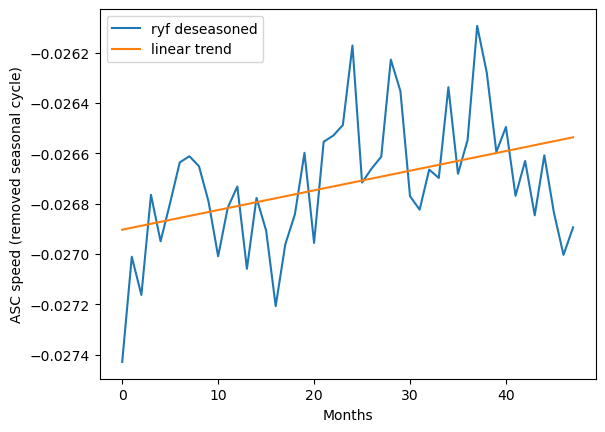

In [43]:
plt.plot(ASC_ryf_deseasoned,label='ryf deseasoned')
plt.plot(xs,trendpoly(xs),label='linear trend')
plt.legend()
plt.ylabel('ASC speed (removed seasonal cycle)')
plt.xlabel('Months')

ASC in RYF has a decreasing trend. It is pretty small tho (0.009 cm/s/yr)

## Now for the IAF

#### ASC speed

Importing IAF ASC speed

In [44]:
iafU_dir='/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_IAF/'

gl =glob.glob(iafU_dir + "Antarctic_slope_contour_1km_velocities_*******_uv.nc")
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
##importing data from ocean.nc

ASCuv_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')
nyears_iaf = 50 #number of years of IAF output. fix to 60 after running years 2008 to 2018

732 netcdf data files


In [45]:
#After year 2008 all decembers are missing. delete them and calculate it again

In [46]:
# compute daily climatology:
iafU_along =ASCuv_time.u_along_contour
iafV_cross =ASCuv_time.v_cross_contour

In [47]:
from joblib import Parallel, delayed
def ASC_paralel(ASCuv_time,vol_along_contour,n):  
    ASCu_iaf = np.nansum(np.array(ASCuv_time.u_along_contour.isel(time=n).T)*np.array(vol_along_contour))/np.nansum(vol_along_contour)
    return ASCu_iaf

In [48]:
%%time
results = Parallel(n_jobs=-1)(delayed(ASC_paralel)(ASCuv_time,vol_along_contour,n) for n in range(732))

ASCu_iaf=results

CPU times: user 5min, sys: 16 s, total: 5min 16s
Wall time: 5min 15s


(1989.0, 1994.0)

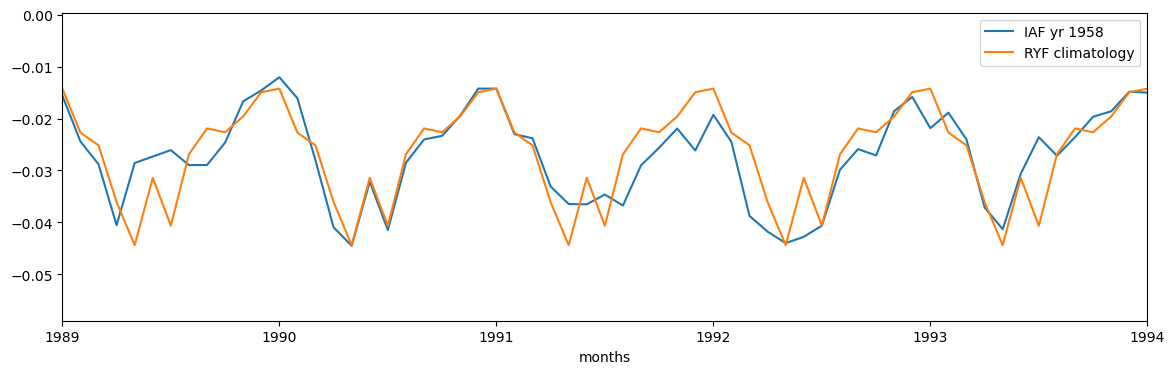

In [49]:
#Checking the first 12 months of IAF against the climatology
fig = plt.figure(figsize=(14,4))
plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf,label='IAF yr 1958')
plt.plot((np.arange(0,732)/12)+1958,ASCu_clim_extended,label='RYF climatology')
plt.legend()
plt.xlabel('months')
plt.xlim(1989,1994)

Notice there is this weird peak in the month 5 (June) of the climatology, that creates a "W" shape in the climatology. At first I will just remove the climatology as it is,but later I might consider smoothing the climatology so I can remove the weird dip. 

__NOTICE__: This dip on June seem to be something specific of the year 1990, used to force RYF< so it is something in its atmospheric forcing. So it is best to remove the signal coming from IAF seasonal cycle itself

In [50]:
ASCu_iaf_deseasoned_with_ryf= ASCu_iaf - (ASCu_clim_extended-np.mean(ASCu_clim))

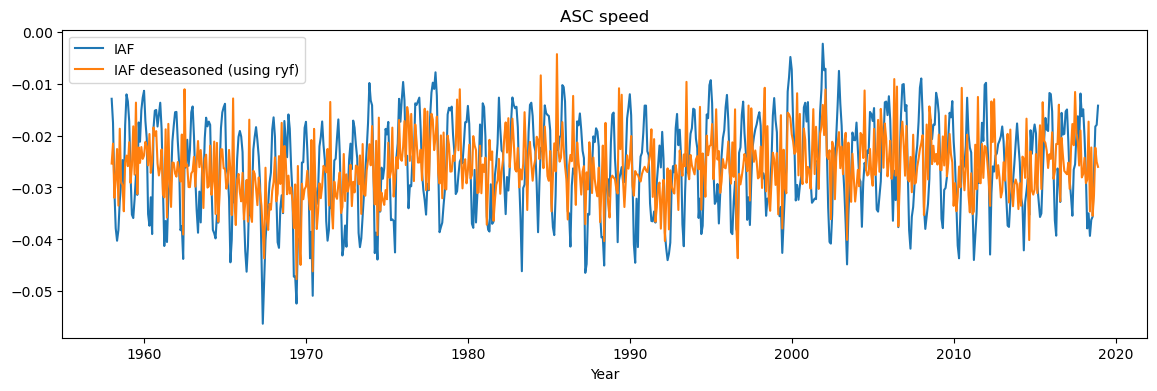

In [51]:
fig = plt.figure(figsize=(14,4))
plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf,label='IAF')
plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf_deseasoned_with_ryf,label='IAF deseasoned (using ryf)')
plt.title('ASC speed')
plt.xlabel('Year')
plt.legend()

I am not sure how many of these wiggle come from that anomaly in june 1990, so I will just calculate the seasonal cycle in iaf, and remove it from the iaf itself

In [52]:
iaf_season=np.tile(np.mean(np.reshape(ASCu_iaf,[61,12]),0),61)
ASCu_iaf_deseasoned_with_iaf= ASCu_iaf - (iaf_season-np.mean(iaf_season))

is there any trend in the deseasoned IAF?

In [53]:
xsiaf=np.arange(0,732)
trendiaf = np.polyfit(xsiaf,ASCu_iaf_deseasoned_with_iaf,1)
trendpolyiaf = np.poly1d(trendiaf) 
ysiaf=trendpolyiaf(xsiaf)

trendvalueiaf=((ysiaf[-1]-ysiaf[0])/732)*12*100 #(cm/s)/yr
trendvalueiaf

0.005171161896086662

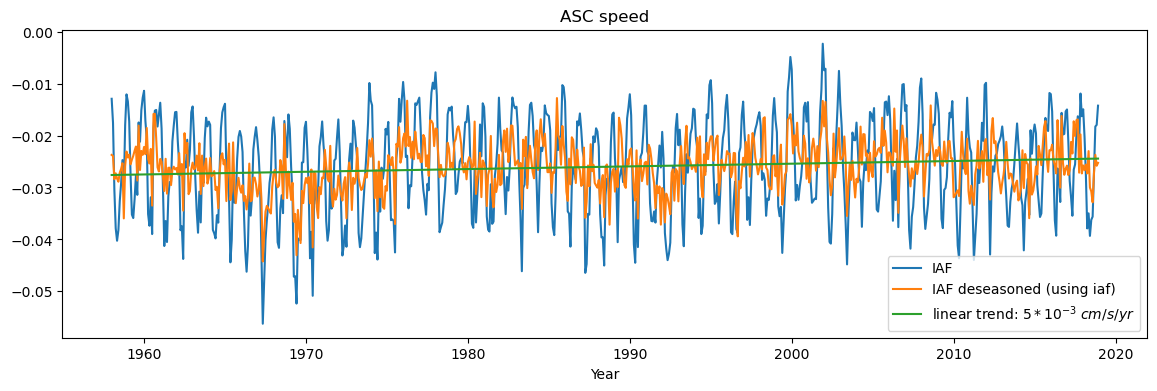

In [54]:
fig = plt.figure(figsize=(14,4))
plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf,label='IAF')
plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf_deseasoned_with_iaf,label='IAF deseasoned (using iaf)')
plt.plot((np.arange(0,732)/12)+1958,trendpolyiaf(xsiaf),label=r"linear trend: $5*10^{-3}\ cm/s/yr$")
plt.title('ASC speed')
plt.xlabel('Year')
plt.legend()

I guess it kinda looks similar, maybe a little less noisy. There is also a very small linear trend towards a decreasing ASC.

#### Cross Slope heat transport (1km isobath)

In [55]:
#importing Cross 1000m isobath heat transport
iaf_HT = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v140_iaf_cycle3/Ant_cross_slope_heat_terms_online_1000m_'
gl =glob.glob(iaf_HT + "*******.nc")
gl=sorted(gl)
Heat_transp_time_iaf=xr.open_mfdataset(gl, concat_dim='time', combine='nested')
IAF_THT_accross_contour = np.nansum(Heat_transp_time_iaf.heat_trans_across_contour,1)

Calculating the deseasoned HT on IAF

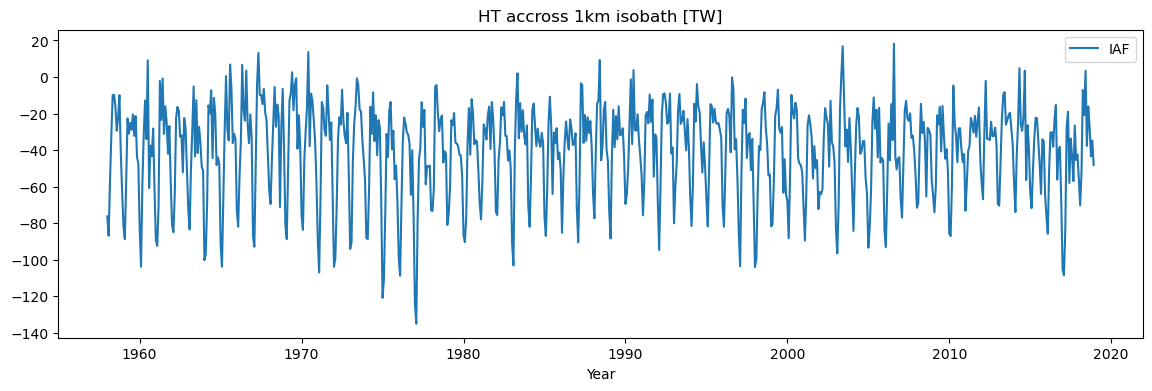

In [56]:
#total heat transport accross the 1km isobath
fig = plt.figure(figsize=(14,4))
plt.plot((np.arange(0,732)/12)+1958,IAF_THT_accross_contour/1e12,label='IAF')
plt.title('HT accross 1km isobath [TW]')
plt.xlabel('Year')
plt.legend()

Transports above are not deseasoned. Lets deseason it to see it to correlate to the deseasoned ASC speed ( It will tells us if a possible similarity between curves are due to the common seasonal cycle, or if it extends to other timescales)

In [57]:
HT_iaf_season=np.tile(np.mean(np.reshape(IAF_THT_accross_contour,[61,12]),0),61)
IAF_THT_deseasoned_with_iaf= IAF_THT_accross_contour - (HT_iaf_season-np.mean(HT_iaf_season))

Getting the linear trend in the HT data

In [58]:
xsiaf=np.arange(0,732)
HTtrendiaf = np.polyfit(xsiaf,IAF_THT_deseasoned_with_iaf,1)
HTtrendpolyiaf = np.poly1d(HTtrendiaf) 
HTysiaf=HTtrendpolyiaf(xsiaf)

HTtrendvalueiaf=((HTysiaf[-1]-HTysiaf[0])/732)*12*100 #(cm/s)/yr
HTtrendvalueiaf/1e12 #in TW/yr

-0.6620721575428918

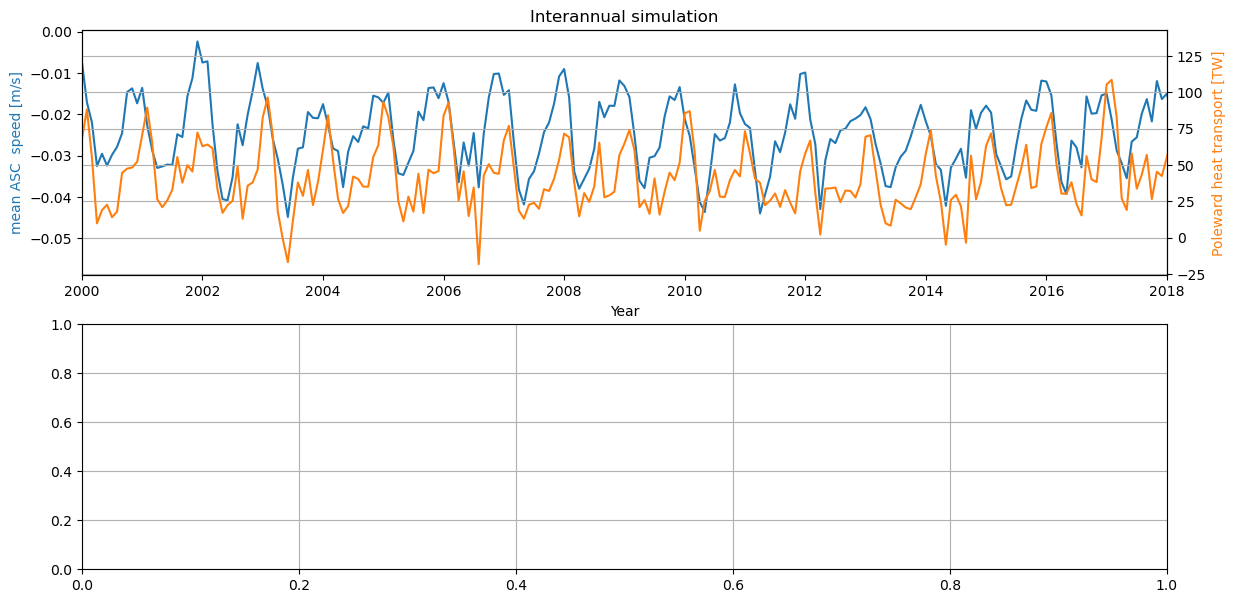

In [90]:
fig,ax = plt.subplots(2,1,figsize=(14, 7))
#fig.tight_layout(pad=2.0)

#subplot1
ax[0].set_title('Interannual simulation')
ax[0].plot((np.arange(0,732)/12)+1958,ASCu_iaf,label=r'U$_{1km}$',color='tab:blue')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('mean ASC  speed [m/s]',color='tab:blue')
plt.grid()
#plt.xticks([1,6,12,18,24,30,36,42,48])




ax2=ax[0].twinx()
plt.plot((np.arange(0,732)/12)+1958,-IAF_THT_accross_contour/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax2.set_ylabel('Poleward heat transport [TW]',color='tab:orange')
plt.grid()





# plt.plot((np.arange(0,732)/12)+1958,IAF_THT_accross_contour/1e12,label='HT')
# plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf,label='ASC speed')
plt.xlim(2000,2018)

plt.savefig( 'IAF_unfiltered.png')

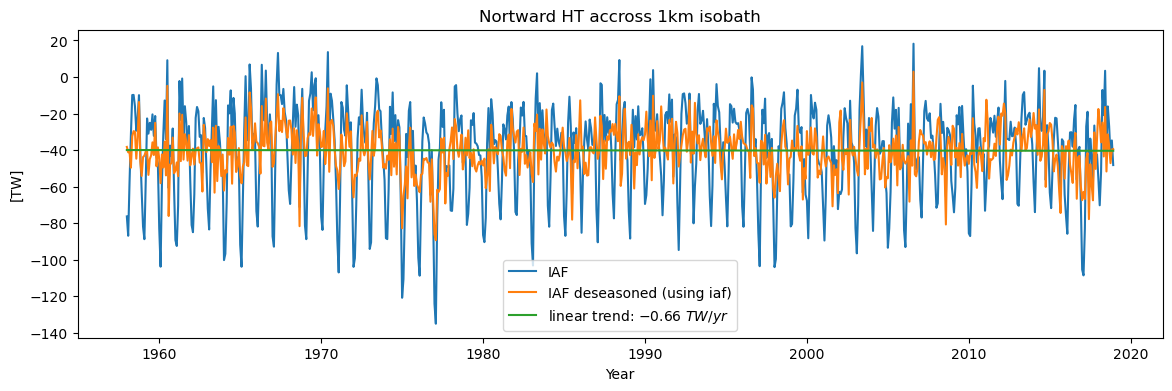

In [60]:
fig = plt.figure(figsize=(14,4))
plt.plot((np.arange(0,732)/12)+1958,IAF_THT_accross_contour/1e12,label='IAF')
plt.plot((np.arange(0,732)/12)+1958,IAF_THT_deseasoned_with_iaf/1e12,label='IAF deseasoned (using iaf)')
plt.plot((np.arange(0,732)/12)+1958,HTysiaf/1e12,label=r"linear trend: $-0.66\ TW/yr$")
plt.title('Nortward HT accross 1km isobath')
plt.ylabel('[TW]')
plt.xlabel('Year')
plt.legend()

Can we correlate the HT accross the 1km isobath with the ASC speed on IAF? How does this correlation change when we remove the seasonal cycle?

In [61]:
#correlation coefficient between ASC speed and HT
IAFcoeffpC = np.corrcoef(ASCu_iaf,IAF_THT_accross_contour/1e12)
IAFcoeffpC_deseasoned = np.corrcoef(ASCu_iaf_deseasoned_with_iaf,IAF_THT_deseasoned_with_iaf/1e12)


IAFcoeffpC[1,0],IAFcoeffpC_deseasoned[1,0]

(-0.6611909850765582, -0.5303074602050691)

Calculating the linear fitting of the curves

In [62]:

regIAF = np.polyfit(ASCu_iaf,IAF_THT_accross_contour/1e12,1)
regIAF_t = np.poly1d(regIAF) 
yregIAF_t=regIAF_t(ASCu_iaf)



regIAF_deseasoned = np.polyfit(ASCu_iaf_deseasoned_with_iaf,IAF_THT_deseasoned_with_iaf/1e12,1)
regIAF_t_deseasoned = np.poly1d(regIAF_deseasoned) 
yregIAF_t_deseasoned=regIAF_t_deseasoned(ASCu_iaf_deseasoned_with_iaf)

dHTdASC= ((np.nanmin(yregIAF_t)  - np.nanmax(yregIAF_t)) / (np.nanmax(ASCu_iaf) - np.nanmin(ASCu_iaf)))/100
dHTdASC_iaf_deseasoned= ((np.nanmin(yregIAF_t_deseasoned)  - np.nanmax(yregIAF_t_deseasoned)) / (np.nanmax(ASCu_iaf_deseasoned_with_iaf) - np.nanmin(ASCu_iaf_deseasoned_with_iaf)))/100

dHTdASC,dHTdASC_iaf_deseasoned #in TW/cm/s


#for the text exclusively
bstart = "\033[1m"
bend = "\033[0;0m"


print( bstart+"WITH SEASONAL CYCLE:"+bend  +" For every 1 cm/s decrease in ASC speed, poleward heat transport increases by " + \
     str(np.round(-dHTdASC,0)) +" TW  \n\n" \
    + bstart+"WITHOUT SEASONAL CYCLE:"+bend +" For every 1 cm/s decrease in ASC speed, poleward heat transport increases by " +\
     str(np.round(-dHTdASC_iaf_deseasoned,0)) + "TW \n\n" + \
     bstart+"GUESS:"+bend +" Seasonal variations in ASC (IAF) can alter the poleward heat transport at a rate of 4 TW/cm/s?")


WITH SEASONAL CYCLE: For every 1 cm/s decrease in ASC speed, poleward heat transport increases by 18.0 TW  

WITHOUT SEASONAL CYCLE: For every 1 cm/s decrease in ASC speed, poleward heat transport increases by 14.0TW 

GUESS: Seasonal variations in ASC (IAF) can alter the poleward heat transport at a rate of 4 TW/cm/s?


The could mean that {sub+supra}seasonal ASC variability can have a stronger (14 TW/cm/s) control on polward heat transport 

Text(0, 0.5, 'HT [TW]')

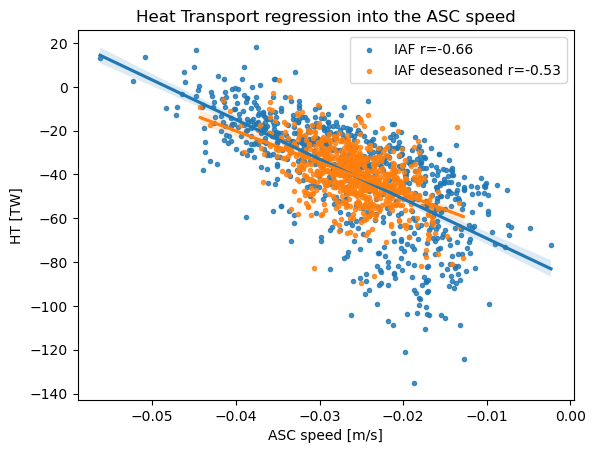

In [63]:
#regression plots
sns.regplot(x=ASCu_iaf, y=IAF_THT_accross_contour/1e12, marker='.',label=r"IAF r=" + str(np.real(int(IAFcoeffpC[1,0]*100))/100))
sns.regplot(x=ASCu_iaf_deseasoned_with_iaf, y=IAF_THT_deseasoned_with_iaf/1e12, marker='.',label=r"IAF deseasoned r=" + str(np.real(int(IAFcoeffpC_deseasoned[1,0]*100))/100))

plt.legend()
plt.title('Heat Transport regression into the ASC speed')
plt.xlabel('ASC speed [m/s]')
plt.ylabel('HT [TW]')

There is definetly a valid correlation here, which seems to decrease (by just a little tho) when we remove the seasonal cycle. 

**WE CAN FILTER THE VARIABILITY AT PERIODS LONGER THAN 12 MONTHS. THIS WILL ISOLATE THE SUBSEASONAL VARIATIONS, WHERE MESOSCALE EDDIES HAVE A STRONG PRESENCE, AND CAN HELP US UNDERSTAND TO WHICH EXTENT THE EDDY REPRESENTATION (MODELS WITH FINER RESOLUTION) CAN AFFECT THE POLEWARD HEAT TRANSPORT!**

#### HIGH PASS FILTERING

Here I will be filtering any periods longer than 3 months, to end up with timescale of mesoscale eddy activity

In [64]:
import scipy

b, a = scipy.signal.butter(6, 1/3,'highpass')
ASC_filtered = scipy.signal.filtfilt(b, a, ASCu_iaf_deseasoned_with_iaf)+np.nanmean(ASCu_iaf_deseasoned_with_iaf)
IAF_filtered = scipy.signal.filtfilt(b, a, IAF_THT_deseasoned_with_iaf/1e12)+np.nanmean(IAF_THT_deseasoned_with_iaf/1e12)

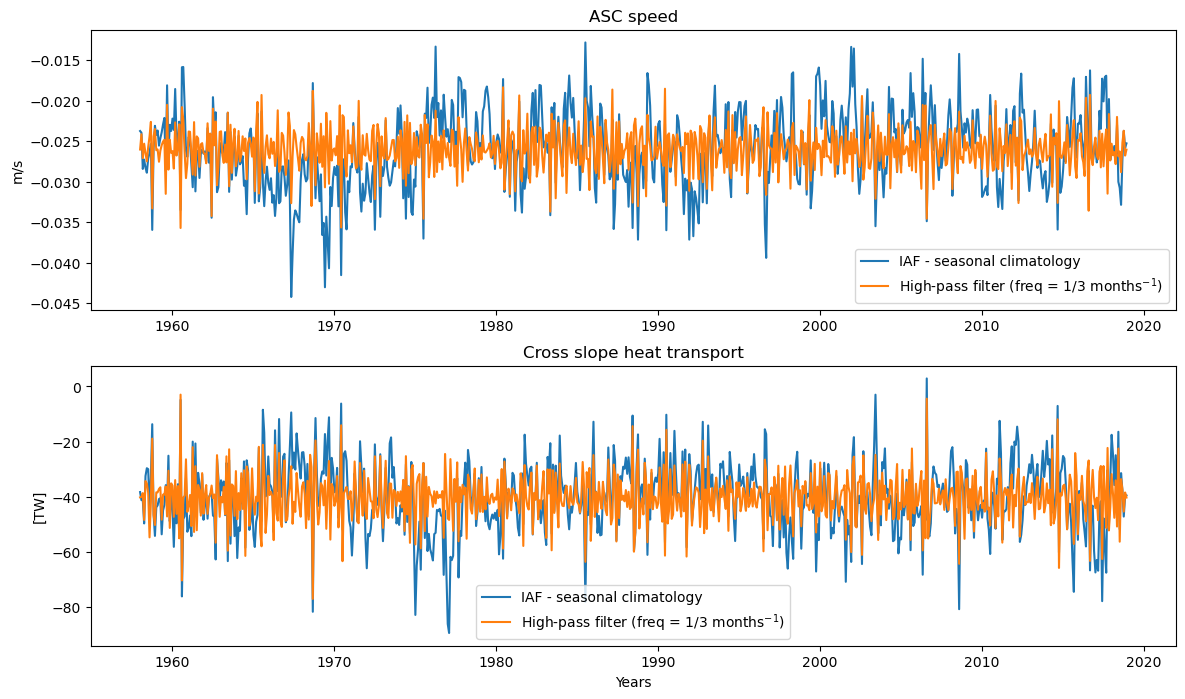

In [69]:
fig = plt.figure(figsize=(14,8))
plt.subplot(2,1,1)
plt.plot((np.arange(0,732)/12)+1958,ASCu_iaf_deseasoned_with_iaf, label='IAF - seasonal climatology ')
plt.plot((np.arange(0,732)/12)+1958,ASC_filtered, label=r"High-pass filter (freq = 1/3 months$^{-1}$)")
plt.legend()
plt.ylabel('m/s')
plt.title('ASC speed')


plt.subplot(2,1,2)
plt.plot((np.arange(0,732)/12)+1958,IAF_THT_deseasoned_with_iaf/1e12, label='IAF - seasonal climatology ')
plt.plot((np.arange(0,732)/12)+1958,IAF_filtered, label=r"High-pass filter (freq = 1/3 months$^{-1}$)")
plt.legend()
plt.xlabel('Years')
plt.title('Cross slope heat transport')
plt.ylabel('[TW]')

plt.savefig( 'IAF_ASC_HT.png')

It seems like a lot of the variability here comes from these fine scale processes ( probably eddies?)

Lets remake the regression plots now to see how the correations and curves change

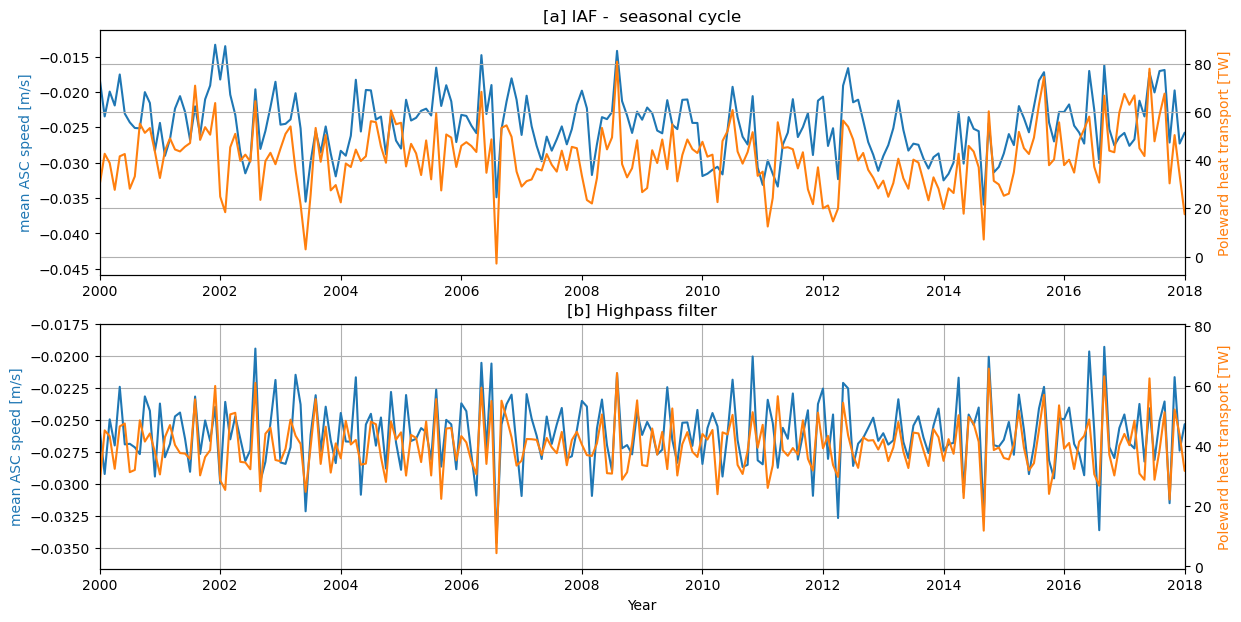

In [91]:
fig,ax = plt.subplots(2,1,figsize=(14, 7))
#fig.tight_layout(pad=2.0)

#subplot1
ax[0].set_title('[a] IAF -  seasonal cycle')
ax[0].plot((np.arange(0,732)/12)+1958,ASCu_iaf_deseasoned_with_iaf, label='IAF - seasonal climatology ')

ax[0].set_ylabel('mean ASC speed [m/s]',color='tab:blue')
ax[0].set_xlim(2000,2018)
plt.grid()


ax2=ax[0].twinx()
plt.plot((np.arange(0,732)/12)+1958,-IAF_THT_deseasoned_with_iaf/1e12, label='IAF - seasonal climatology ',color='tab:orange')
ax2.set_ylabel('Poleward heat transport [TW]',color='tab:orange')



ax[1].set_title('[b] Highpass filter')
ax[1].plot((np.arange(0,732)/12)+1958,ASC_filtered, label=r"High-pass filter (freq = 1/3 months$^{-1}$)")
ax[1].set_ylabel('mean ASC speed [m/s]',color='tab:blue')
#plt.xlabel('Year')
ax[1].set_xlim(2000,2018)
ax[1].set_xlabel('Year')
plt.grid()


axb=ax[1].twinx()
plt.plot((np.arange(0,732)/12)+1958,-IAF_filtered, label=r"High-pass filter (freq = 1/3 months$^{-1}$)",color='tab:orange')
axb.set_ylabel('Poleward heat transport [TW]',color='tab:orange')


plt.savefig( 'IAF_filtered.png')

In [66]:
#correlation coefficient between ASC speed and HT
IAFcoeffpC_deseasonedf = np.corrcoef(ASC_filtered,IAF_filtered)


IAFcoeffpC_deseasonedf[1,0]

-0.5777737647882556

In [67]:
regIAF_deseasonedf = np.polyfit(ASC_filtered,IAF_filtered,1)
regIAF_t_deseasonedf = np.poly1d(regIAF_deseasonedf) 
yregIAF_t_deseasonedf=regIAF_t_deseasoned(ASC_filtered)

dHTdASC_iaf_deseasonedf= ((np.nanmin(yregIAF_t_deseasonedf)  - np.nanmax(yregIAF_t_deseasonedf)) / (np.nanmax(ASC_filtered) - np.nanmin(ASC_filtered)))/100

dHTdASC_iaf_deseasonedf #in TW/cm/s


-14.37147205784135

The fact that the dHTdASC in the filtered data is so similar to the unfiltered one suggests taht almost all the  ASC/HT "coupled variability" here occurs in periods lower than 3  months, and are likely due to eddy activity?

Text(0, 0.5, 'HT [TW]')

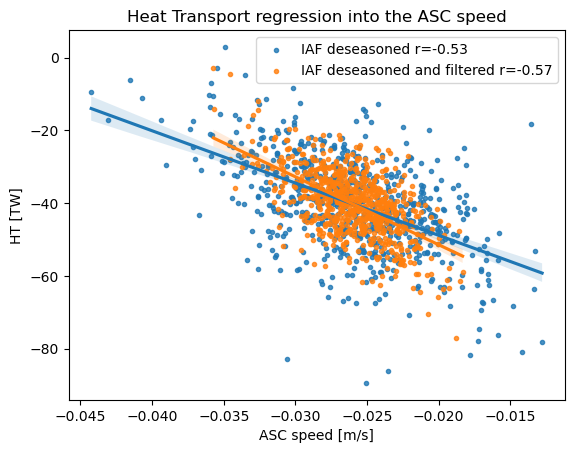

In [68]:
#regression plots
sns.regplot(x=ASCu_iaf_deseasoned_with_iaf, y=IAF_THT_deseasoned_with_iaf/1e12, marker='.',label=r"IAF deseasoned r=" + str(np.real(int(IAFcoeffpC_deseasoned[1,0]*100))/100))
sns.regplot(x=ASC_filtered, y=IAF_filtered, marker='.',label=r"IAF deseasoned and filtered r=" + str(np.real(int(IAFcoeffpC_deseasonedf[1,0]*100))/100))


plt.legend()
plt.title('Heat Transport regression into the ASC speed')
plt.xlabel('ASC speed [m/s]')
plt.ylabel('HT [TW]')

Notice that the curve inclination is also bigger in the filtered case, so we have even stronger rate of change in HT, as ASC changes in timescales smaller than 3 months

This will be the hook that I will use explain that we expect that we might have very different results in models with higher resolution, that expressly resolve eddies in high latitudes

#### Extra for IUGG poster

Plot of mean daily speed at 45m depth in the panan01, panan005 and panan0025

In [94]:
session2 = cc.database.create_session()

In [99]:
panan01 = 'panant-01-zstar-ACCESSyr2'
panan005 = 'panant-005-zstar-ACCESSyr2'
cc.querying.get_ncfiles(session2, experiment=panan01)

,ncfile,index_time
0,output000/19910101.ice_month.nc,2023-06-22 00:32:49.152706
1,output000/19910101.ocean_month.nc,2023-06-22 00:33:12.100549
2,output000/19910101.ocean_month_rho2.nc,2023-06-22 00:32:57.954675
3,output000/19910101.ocean_month_z.nc,2023-06-22 00:32:16.344986
4,output000/19910101.ocean_static.nc,2023-06-22 00:32:47.242746
...,...,...
386,restart039/MOM.res_6.nc,2023-06-23 01:26:50.961241
387,restart039/MOM.res_7.nc,2023-06-23 01:26:45.571741
388,restart039/MOM.res_8.nc,2023-06-23 01:27:01.362818
389,restart039/MOM.res_9.nc,2023-06-23 01:26:53.290585


In [113]:
Uo_01 = cc.querying.getvar(expt=panan01, variable='uo', session=session2)

In [107]:
# vars_01deg = cc.querying.get_variables(session, experiment=panan01)
# vars_01deg[vars_01deg['name'].str.lower().str.contains('uo')]

In [ ]:
# We still dont have a database for panan0025. Lets import it separately then